Import Relevant Libraries

In [6]:
from keras.models import Sequential
from keras.layers import Input, Dropout, Dense, LSTM, Conv1D, Bidirectional
from keras.preprocessing import sequence
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np

Loading Data Set

In [7]:
train = pd.read_csv("../Dataset/Train.csv")
test = pd.read_csv("../Dataset/Test.csv")

X = train.drop(["Target"], axis = 1).copy()
y = train.drop(["Sequences"], axis = 1).copy()

X_test = test.drop(["Target"], axis = 1).copy()
y_test = test.drop(["Sequences"], axis = 1).copy()

k = 1
top_words = 26**k
max_review_length = 1500

K-Mers Function

In [8]:
# takes seq (string) and k (int), returns list of enumerated kmers (list)
def get_kmers(seq, k):
    return " ".join([seq[i:i+k] for i in range(len(seq) - k)])

Data Processing

In [9]:
X['Words'] = X.apply(lambda x: get_kmers(x["Sequences"], k), axis=1)
X = X.drop("Sequences", axis=1)
X_test['Words'] = X_test.apply(lambda x: get_kmers(x["Sequences"], k), axis=1)
X_test = X_test.drop("Sequences", axis=1)

In [10]:
tokenizer = Tokenizer(num_words = top_words, oov_token=1, char_level = False)
tokenizer.fit_on_texts(X['Words'])
X_train = tokenizer.texts_to_sequences(X['Words'])
y_train = y
X_test = tokenizer.texts_to_sequences(X_test['Words'])
y_test = y_test

Truncation and Padding

In [11]:
X_train_post = sequence.pad_sequences(X_train, maxlen=max_review_length, padding="post")
X_test_post = sequence.pad_sequences(X_test, maxlen=max_review_length, padding="post")



In [12]:

X_train_int = np.array(X_train_post, dtype=int)
y_train = np.array(y_train, dtype=int)
X_test_int = np.array(X_test_post, dtype=int)
y_test = np.array(y_test, dtype=int)

In [13]:
onehot_encoder = OneHotEncoder(sparse_output=False, dtype=np.int8)
X_train_shape = X_train_int.shape
X_train_linear = np.reshape(X_train_int, (-1,1))
X_train_oh = onehot_encoder.fit_transform(X_train_linear)

X_test_shape = X_test_int.shape
X_test_linear = np.reshape(X_test_int, (-1,1))
X_test_oh = onehot_encoder.transform(X_test_linear)

In [14]:
X_train = np.reshape(X_train_oh, (X_train_shape[0], -1, 26))
X_test = np.reshape(X_test_oh, (X_test_shape[0], -1, 26))

In [15]:
np.savez("processed_data_2.npz", X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
data = np.load('processed_data_2.npz')
X_train = data['X_train']
y_train = data['y_train']
X_test = data['X_test']
y_test = data['y_test']

In [16]:

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=69)

Model

In [17]:
model = Sequential()
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
model.add(Conv1D(filters=256, kernel_size=15, strides=10, activation='relu'))
model.add(Bidirectional(LSTM(units=8, dropout=0.5)))
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))
optimizer = Adam(learning_rate=0.002)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 149, 256)       │       100,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 16)             │        16,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,209 (461.75 KB)

 Trainable params: 118,209 (461.75 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
history = model.fit(X_train, y_train, epochs=30, batch_size=64 , validation_data=(X_val, y_val))

Epoch 1/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 49s 166ms/step - accuracy: 0.5705 - loss: 0.6701 - val_accuracy: 0.7344 - val_loss: 0.5527
Epoch 2/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 28s 144ms/step - accuracy: 0.7074 - loss: 0.5900 - val_accuracy: 0.7540 - val_loss: 0.5170
Epoch 3/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 27s 142ms/step - accuracy: 0.7365 - loss: 0.5457 - val_accuracy: 0.7710 - val_loss: 0.4812
Epoch 4/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 27s 143ms/step - accuracy: 0.7581 - loss: 0.5102 - val_accuracy: 0.7697 - val_loss: 0.4756
Epoch 5/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 27s 142ms/step - accuracy: 0.7829 - loss: 0.4829 - val_accuracy: 0.7773 - val_loss: 0.4650
Epoch 6/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 27s 143ms/step - accuracy: 0.8068 - loss: 0.4440 - val_accuracy: 0.7900 - val_loss: 0.4566
Epoch 7/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 29s 154ms/step - accuracy: 0.8101 - loss: 0.4211 - val_accuracy: 0.7940 - val_loss: 0.4500
Epoch 8/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 34s 180ms/step - accuracy: 0.8481 - loss: 0

In [19]:
# change the features used for testing here
y_predict = model.predict(X_test)

2615/2615 ━━━━━━━━━━━━━━━━━━━━ 93s 35ms/step


In [20]:
y_predict_binary = list(map(lambda x: int(x[0]>0.5), y_predict))

# change the y_test used for testing here (if using another test case)
accuracy = accuracy_score(y_test, y_predict_binary)
print("Accuracy: ", accuracy)

# change the y_test used for testing here (if using another test case)
cm = confusion_matrix(y_test, y_predict_binary)
print("Confusion Matrix: \n", cm)
tn, fp, fn, tp = cm.ravel()

sensitivity = tp / (tp + fn)

specificity = tn / (tn + fp)

mcc = (tp * tn - fp * fn) / ((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) ** 0.5

# change the y_test used for testing here (if using another test case)
f1 = f1_score(y_test, y_predict_binary)

print(f'sensitivity: {sensitivity}')
print(f'specificity: {specificity}')
print(f'mcc: {mcc}')
print(f'f1 score: {f1}')

Accuracy:  0.5784743716911457
Confusion Matrix: 
 [[39369 27929]
 [ 7343  9036]]
sensitivity: 0.5516820318700776
specificity: 0.5849950964367441
mcc: 0.10920210986208964
f1 score: 0.3387822435512897


In [21]:
history_load = history.history


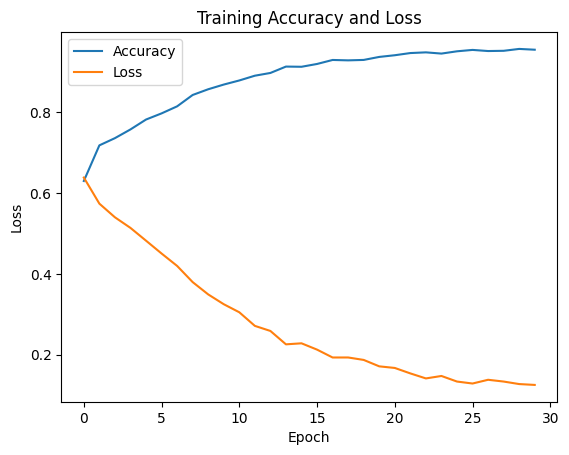

In [22]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history_load['accuracy'])
plt.plot(history_load['loss'])
plt.title('Training Accuracy and Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Accuracy', 'Loss'], loc='upper left')
plt.show()

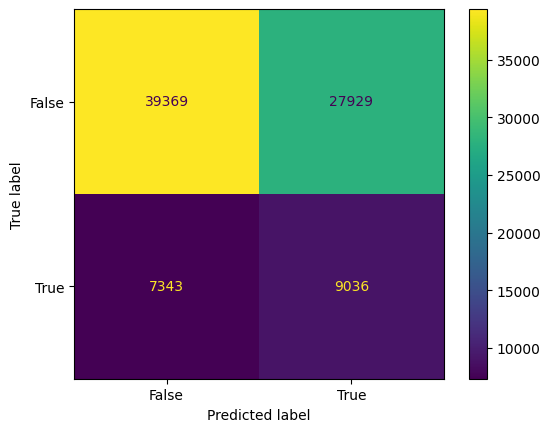

In [23]:
# Plot confusion matrix
from sklearn import metrics
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['False', 'True'])
cm_display.plot()
plt.show()